# Introduction

The aim of this lab is to get familiar with **classification problems** and **logistic regression**. We will be using some code extracts that were implemented last week and build a logistic regression model.

1.   This lab is part of Assignment 1 part 2.
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebooks.
3. A single pdf report should be submitted on QMplus along with the completed Notebooks **for both** this and the Neural Networks notebook (lab 6).
4. The deadline for **both** is **Friday, 17 November 11:59pm**
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
8. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).

---

**POST-FEEDBACK ADDITIONS**:

Any comments or text written in <font color="blue">blue</font> are comments or text I have added based on the feedback given after the correction of the assignment.

---


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# UNUSED...
# from IPython import display
# import typing
# %matplotlib inline

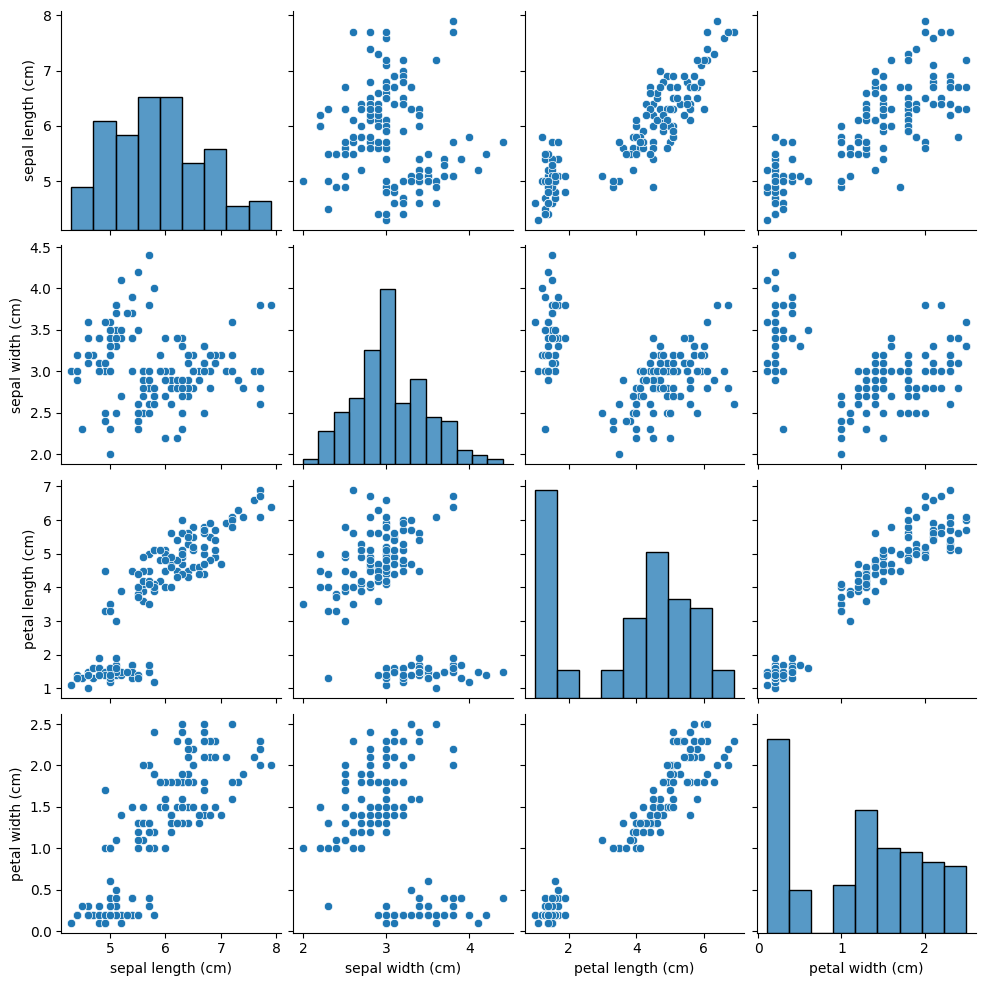

In [ ]:
iris_db = datasets.load_iris(as_frame=True)
sn.pairplot(iris_db.data)

In [ ]:
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42)

x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int().reshape(-1, 1)
y_test = torch.from_numpy(y_test.values).int().reshape(-1, 1)

In [ ]:
# Having a look at the target variable values:
print(f"Unique classes in training data: {y_train.unique()}")
print(f"Unique classes in testing data: {y_test.unique()}")
print(f"Target names: {iris_db.target_names}")

Unique classes in training data: tensor([0, 1, 2], dtype=torch.int32)
Unique classes in testing data: tensor([0, 1, 2], dtype=torch.int32)
Target names: ['setosa' 'versicolor' 'virginica']


We see that the target variable can take integer values that are nominal in nature, not representing quantities but particular labels (of flowers):

- 0 means setosa
- 1 means versicolor
- 2 means virginica

# 1. Single class

## Question 1
<font color="maroon"><u>We again notice that the attributes are on different scales. Use the normalisation method from last lab, to standardize the scales of each attribute on both sets. Plot the normalized and raw training sets; what do you observe? [2 marks] </font></u>

In [ ]:
# Normalization function from part 1 of this assignment:
def norm_set(x:torch.Tensor,mu:torch.Tensor,sigma:torch.Tensor)->torch.tensor:
  return (x-mu)/sigma

In [ ]:
# Obtaining & storing the feature-wise means & standard deviations
# NOTE: Each column corresponds to a feature

"""
REFERENCE:
The below usages of `torch.mean` & `torch.sigma` are explained in part 1 of this
assignment.
"""

mu = {"x_train": torch.mean(x_train, 0)}
sigma = {"x_train": torch.std(x_train, 0)}

# NOTE: Single-item dictionaries are used to increase readability of code

In [ ]:
# Performing normalization on the training set
norm_x_train = norm_set(x_train, mu["x_train"], sigma["x_train"])

# Comparing samples of the normalized & original tensors for reference
print("Original values:\n", x_train[:3, :3])
print("\nNormalized values:\n", norm_x_train[:3, :3])

Original values:
 tensor([[4.6000, 3.6000, 1.0000],
        [5.7000, 4.4000, 1.5000],
        [6.7000, 3.1000, 4.4000]])

Normalized values:
 tensor([[-1.4678,  1.1986, -1.5560],
        [-0.1325,  2.9799, -1.2707],
        [ 1.0814,  0.0854,  0.3842]])


Plotting normalized and raw training data...

In [ ]:
# Function to do the plot in certain way:
def plot_hist(x, title):
  labelList = list(iris_db['data'].keys())
  plt.figure(figsize=(6, 6))
  for i in range(x.shape[1]):
    plt.hist(x[:, i], bins=25, label=labelList[i])
  plt.title(title)
  plt.legend()
  plt.show()

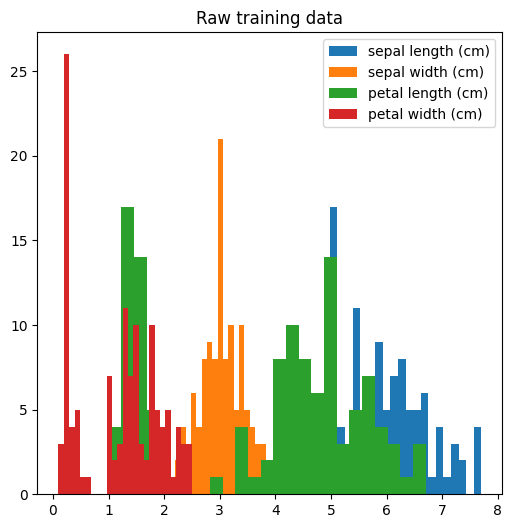

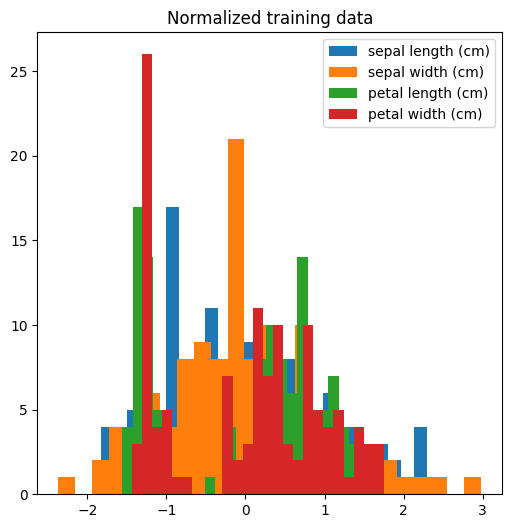

In [ ]:
# Plotting the distributions of training & normalized data
plot_hist(x_train, "Raw training data")
plot_hist(norm_x_train, "Normalized training data")

**OBSERVATIONS**:<br>Plotted above are the histograms of each feature drawn together to see how the values of the features are distributed with respect to each other, A clear difference between the unnormalised data and the normalised data is the distribution of the values. In the normalised version, the values are more packed together; indeed, they all revolve more closely around the mean 0. But we also note that normalisation does not change the way values are distributed within a feature; normalisation only brings all feature values to the same centre and scale (mean and variance). <font color="blue">Finally, we see that the scale of the data per feature, i.e. the degree of variation from the mean is brought closer to each other after normalisation, which is to be expected since we bring the standard deviation of each feature's values to 1 through normalisation.</font>

Normalizing the training & test data for future work...

In [ ]:
x_train = norm_set(x_train, mu["x_train"], sigma["x_train"])
x_test = norm_set(x_test, mu["x_train"], sigma["x_train"])

By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

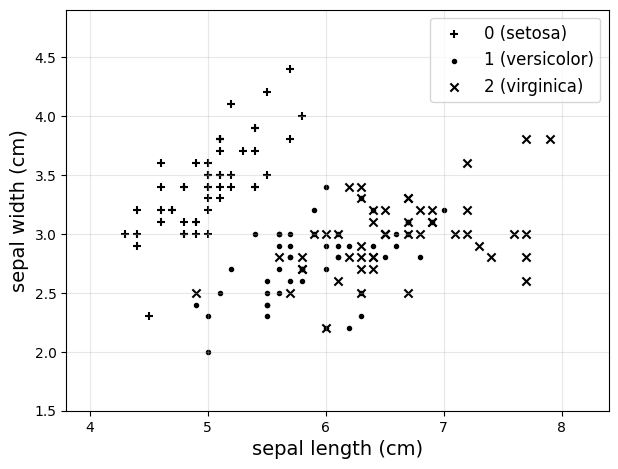

In [ ]:
X = iris_db.data.iloc[:, :2]
Y = iris_db.target
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0],
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l],
      s=35,
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l]))

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()

Is the data linearly separable?

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [ ]:
train_set = x_train[:, :2]
test_set = x_test[:, :2]

# Add a feature for bias
train_set = torch.cat([train_set, torch.ones(train_set.shape[0], 1)], dim=1)
test_set = torch.cat([test_set, torch.ones(test_set.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()

**Sigmoid function**<br>
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email. The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $

---

## Questions 2 & 3
**Q2.** First implement the above function in `def sigmoid()`. [2 marks]

**Q3.** Then, using the implementation of `LinearRegression` from last week as guideline, create a custom pytorch layer for `LogisticRegression` [2 marks]

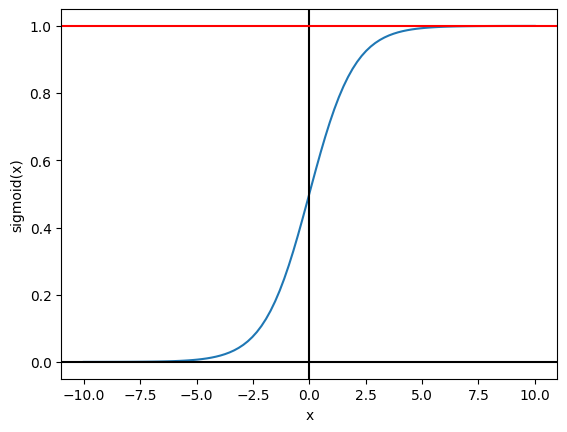

In [ ]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1/(1 + torch.exp(-x))


x = torch.linspace(-10,10, 100)
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# Set label of horizontal axis
ax1.set_xlabel('x')
# Set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
# Draw axes
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
# Drawing a line at y=1 for reference
ax1.axhline(y=1, color='r')

plt.show()

In [ ]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    y = sigmoid(x @ torch.transpose(self.weight, 0, -1))
    return y

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = -\frac{1}{m}\sum_{i=1}^m [y^{(i)} log( h_{\theta}(x^{(i)})) + (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))]$

Which when taking partial derivatives with respect to the vector of weights $\theta$, we get:

$
\frac{\delta J}{\delta \theta} = \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$

Putting this into the gradient descent update equation gives:


$
 \theta_{j} =  \theta_{j} - \alpha \frac{\delta J}{\delta \theta} = \theta_{j} - \frac{\alpha}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$

**NOTE**: To evaluate performance with respect to **cross entropy loss** does not require a division by $m$ (i.e. number of observations), but such a division is helpful when comparing the costs of two datasets on the same variables but with different numbers of observations (ex. it is useful in comparing the training and testing errors), since it brings the cost values to the same scale.

---

## Question 4
Implement the cost in `bce()` and update the `gradient_descent_step()` from last week to update using the partial derivative above. [4 marks]

Cost function...

In [ ]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor):
  # NOTE: bce ==> binary cross entropy
  m = y_true.shape[0]
  J = (y_true*torch.log(y_pred) + (1-y_true)*torch.log(1-y_pred)).sum()
  return (-J/m).item()

Gradient descent function...

In [ ]:
def gradient_descent_step(model: nn.Module, x: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight
  m, n = x.shape

  """
  # POSSIBLE IMPLEMENTATION WITH LOOPS
  # (for conceptual clarity)
  for i in range(N): # For N columns (i.e. N features)
    for j in range(M): # For M rows (i.e. M observations)
      weight[0, i] -= ((lr*x[j, i]*(y_pred[j] - y[j])/M)[0]
  """
  # IMPLEMENTATION WITH TENSOR OPERATIONS
  # (this is much faster than loops)
  weight[0] -= lr*(x * (y_pred-y)).sum(axis=0)/m
  # axis=0 indicates column-wise summing

  model.weight = nn.Parameter(weight, requires_grad=False)

Training loop...

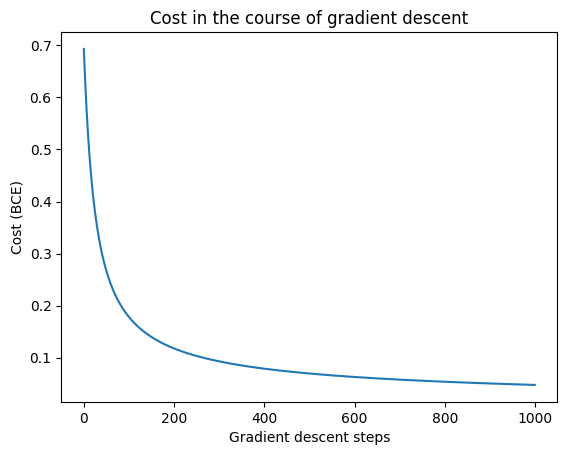


Weights:
Index 0:-3.7661831378936768
Index 1: 2.540623664855957
Index 2:-2.12412691116333

Minimum cost: 0.047883808612823486


In [ ]:
def train(model, x, y, alpha):
  costList = []
  for i in range(1000):
    prediction = model.forward(x)
    costList.append(bce(y, prediction))
    gradient_descent_step(model, x, y, prediction, alpha)

  # Presenting the outcomes:
  plt.plot(list(range(i+1)), costList)
  plt.title("Cost in the course of gradient descent")
  plt.xlabel("Gradient descent steps")
  plt.ylabel("Cost (BCE)")

  plt.show()
  print("\nWeights:")
  for i, w in enumerate(model.weight[0]):
    if w.item() < 0: sign = '-'
    else: sign = ' '
    print(f"Index {i}:{sign}{abs(w.item())}")
  print('\nMinimum cost: {}'.format(min(costList)))

model = LogisticRegression(train_set.shape[1])
alpha = 0.1 # Select an appropriate learning rate
train(model, train_set, setosa_train, alpha)

## Question 5

<u><font color="maroon"> Draw the decision boundary on the test set using the learned parameters. Is this decision boundary separating the classes? Does this match our expectations? [2 marks]</font></u>

Global values for the upcoming plots...

In [ ]:
prediction = model(train_set)
x1, x2 = train_set[:, 0], train_set[:, 1]
# NOTE: x1 ==> sepal length, x2 ==> sepal width

# To help filter the data according to classes:
indicators = [int(y[0])==1 for y in setosa_train]

A small helper function to add details to the upcoming plots and present them neatly...

In [ ]:
def plot_presentation(title):
  plt.title(title)
  plt.xlabel("sepal length (cm)"), plt.ylabel("sepal width (cm)")
  plt.show()

### Plotting classes

Note that we are classifying flowers (as "Setosa" or "Not Setosa") with respect to sepal length & sepal width (the two predictor variables). Plotting scatterplot of classified points without decision boundary...

In [ ]:
def plot_points_by_class():
  # Filtering the data with respect to their classes:
  # CLASS 1: Setosa
  x1_true = [x1[i] for i in range(len(x1)) if indicators[i]]
  x2_true = [x2[i] for i in range(len(x2)) if indicators[i]]
  # CLASS 2: Not Setosa
  x1_false = [x1[i] for i in range(len(x1)) if not indicators[i]]
  x2_false = [x2[i] for i in range(len(x2)) if not indicators[i]]

  # Plotting data:
  plt.scatter(x1_true, x2_true, marker='+', s=30, label="Setosa")
  plt.scatter(x1_false, x2_false, marker='.', label="Not Setosa")

  # Displaying legend:
  plt.legend()

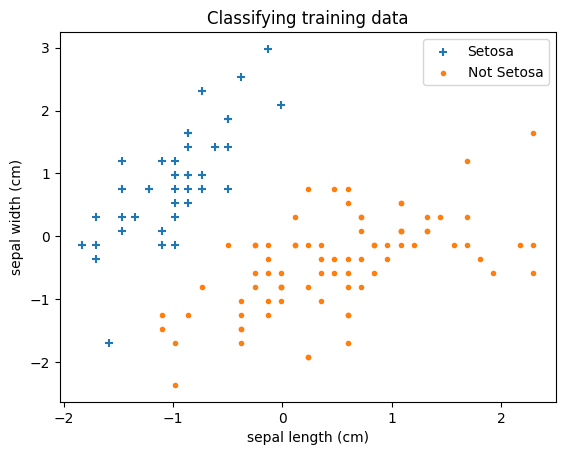

In [ ]:
plot_points_by_class()
plot_presentation("Classifying training data")

### Plotting decision boundary

> KEY REFERENCE: https://medium.com/analytics-vidhya/decision-boundary-for-classifiers-an-introduction-cc67c6d3da0e

#### General approach
For convenience, let $y$ denote the predicted target variable, let $x_1$ denote sepal length, and let $x_2$ denote sepal width ($x_1$ and $x_2$ are the predictor variables here). In the previous section's scatterplot, we see that the axes are the two predictor variables ($x_1$ is the horizontal axis, while $x_2$ is the vertical axis). This scatterplot is done within a finite grid.
<br><br>
In order visualise the decision boundary as predicted by our model, we must obtain the line going through the set of coordinates whose predicted value lies at or close to $0.5$. This is because $0.5$ is the decision value; any coordinate $(p,q)$ with a $y$ value higher than $0.5$ is classified as $1$ while every coordinate $(p,q)$ with a $y$ value lower than $0.5$ is classified as $0$.
<br><br>
To do the above, we can do the following:

- Obtain the $y$ value for every possible coordinate $(p,q)$ in a finite grid, where $p \in x_1, q \in x_2$
- Plot a contour line at $y=f((p,q))=0.5$ (where $f$ is the model)

**TERMINOLOGY**: **Contour line**:<br>_A contour line (also isoline, isopleth, or isarithm) of a function of two variables is a curve along which the function has a constant value, so that the curve joins points of equal value_ (source: https://en.wikipedia.org/wiki/Contour_line).

---

The above goals can be obtained using the following approach:

- Create a meshgrid for a range of values from the axes $x_1$ & $x_2$
- Use this meshgrid to create a tensor of predictor values (with bias)
- Apply the model tp the above tensor to obtain the predictions
- Using the predictions & the previous meshgrid, plot the contour

_To do this, we need the following two functions_...

---

#### 1. `torch.meshgrid`
This function does the following:

- Takes an array of values $x_1$ of size $n_1$ from axis 1
- Takes an array of values $x_2$ of size $n_2$ from axis 2
- Returns a grid of all possible pairs $(p, q)$ where $p \in x_1, q \in x_2$

Essentially, this function returns the Cartesian product of $x_1$ and $x_2$. This grid of combinations is given in the form of a tuple containing two arrays of row vectors. The nature of these arrays of row vectors depends on the indexing used (given by the argument `indexing`).
<br><br>**CASE 1**: `indexing="ij"` **(default)**:<br>
The first element of the tuple is the array of $n_1$ row vectors wherein row vector $i$ is the array of $n_2$ copies of the $i$th element of $x_1$. The second element of the tuple is the array of $n_1$ copies of the array $x_2$.
<br><br>**CASE 1**: `indexing="xy"` **(kind of the reverse of "ij")**:<br>
The first element of the tuple is the array of $n_2$ copies of the array $x_1$. The second element of the tuple is the array of $n_2$ row vectors wherein row vector $i$ is the array of $n_1$ copies of the $i$th element of $x_2$.
<br><br>
Both of these arrangements are such that matching value $i$ from row $j$ of the first element of the tuple to the value $j$ from row $j$ of the second element of the tuple gives you a pair $(p, q)$ where $p \in x_1, q \in x_2$. Doing this for all $i \in [0, n_2]$ and all $j \in [0, n_1]$ gives you all the possible pairs of the values of $x_1$ and $x_2$.
<br><br>
_This function can be used to generate a grid of coordinates given two arrays of values corresponding to different dimensions/axes_.

> REFERENCE: https://pytorch.org/docs/stable/generated/torch.meshgrid.html

---

#### 2. `matplotlib.pyplot.contour`
This function inputs:

- Two lists of row vectors $X$ & $Y$ that together form a meshgrid
- The list of row vectors $Z$ of functional values for each coordinate of the meshgrid

Of course, the shapes and ordering of each of the above must match, or else the contour line cannot be properly constructed. Another important (though optional) argument is `levels`, which specifies the number of contour lines to be drawn from the range, i.e. between the minimum and maximum values of $Z$. Given $n$ levels, $n$ contour lines are calculated for $n$ functional values uniformly spread across the range of $Z$. Hence, `levels=1` plots the contour line for the functional value at the middle of the range. In our case, this value is $0.5$ (since the target ranges from 0 to 1), which fits our purpose perfectly.

> REFERENCE: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.contour.html

In [ ]:
def plot_decision_boundary():
  x1_range = torch.linspace(min(x1)-0.5, max(x1)+0.5, 100)
  x2_range = torch.linspace(min(x2)-0.5, max(x2)+0.5, 100)
  # NOTE: Our ranges are slightly larger than needed for padding the grid

  xGrid = torch.meshgrid(x1_range, x2_range, indexing="ij")
  # Saving the shape of the grid created (for later use):
  xShape = xGrid[0].shape
  # Obtaining the required row size for making predictions per coordinate:
  n = xShape[0] * xShape[1]
  # Creating the tensor on which to predict (with bias field added):
  x = torch.cat((xGrid[0].ravel(), xGrid[1].ravel(), torch.ones(n)),
            dim=0).reshape(3, n).T
  # NOTE 1: The .ravel method is explained below this code block
  # NOTE 2: The above tensor must be such that each variable is a column

  # Obtaining the predictions:
  y = model(x)
  # Reshaping the predictions to match the grid shape:
  y = y.reshape(xShape)

  plt.contour(xGrid[0], xGrid[1], y, levels=1)

**PROGRAMMING NOTE**: `ravel` **method for** `torch.tensor` **objects**:<br> This function returns a contiguous flattened tensor whose values correspond to the values of inputted multi-dimensional tensor in the order of left-to-rigt, top-to-bottom.

> REFERENCE: https://pytorch.org/docs/stable/generated/torch.ravel.html

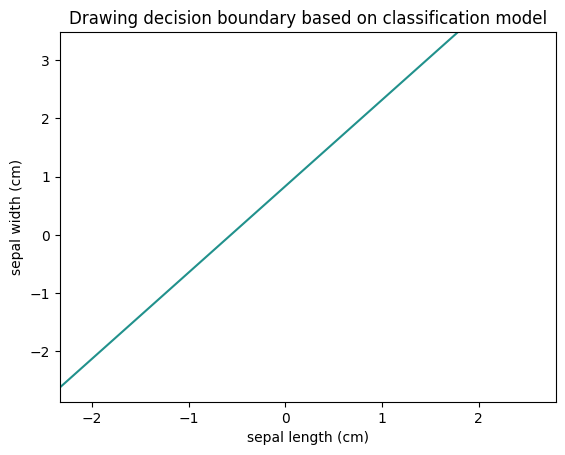

In [ ]:
plot_decision_boundary()
plot_presentation("Drawing decision boundary based on classification model")

### Plotting classes with decision boundary

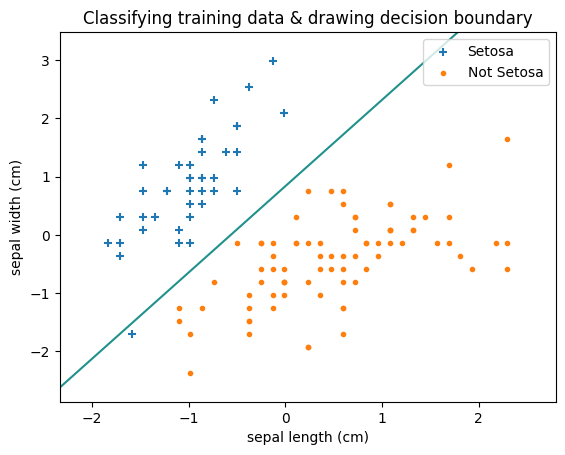

In [ ]:
plot_points_by_class()
plot_decision_boundary()
plot_presentation("Classifying training data & drawing decision boundary")

**OBSERVATIONS**:<br>The above decision boundary almost completely (excluding one point) partitions the data (consisting of value pairs of sepal length and sepal width) according to the respective classes ("Setosa", "Not Setosa") to which they belong. The decision boundary is a reflection of the trained sigmoid function used for the above linear classifier. For a linear decision boundary to be even feasible, there needs to be a clear threshold for the sigma function that maps a linear combination of the vector of inputs $x$ and weights $w$ (i.e. $x^Tw$)$ to one of two classes. If such a threshold does not exist, then the data is not linearly spearable and an accurate decision boundary is impossible to draw. But above, we see that the data here is linearly separable and each linear combination of inputs and weights does fall to either one side of a threshold value (0.5 in our case).

# 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach (refer to the lecture notes for details). We will also be using all 4 attributes for the classification.
<br><br>
**RECAP**: **How classes are represented in the original dataset**:<br>The target variable can take integer values that are nominal in nature, not representing quantities but particular labels (of flowers):

- 0 means setosa
- 1 means versicolor
- 2 means virginica

## Obtaining the required representation for the target variable

**PROGRAMMING NOTE**: **The** `torch.nn.functional` **module**:<br>This module contains numerous functions that can be used in convolutions.

---

### About convolution
Convolution is a mathematical operation on two functions $f_1$ and $f_2$ that produces a third function $f_3=(f_1*f_2)$ that maps $f_1$ to its modification via $f_2$, i.e. it expresses how the shape of one is modified by the other. Note that the term convolution refers to both the result function $f_3$ and the process of computing it.

**SIDE NOTE 1**: _The term convolution comes from the latin con (with) + volutus (rolling)_.

<font color="magenta">**_The convolution can be given as an integral of the product of two functions_** $f_1$ and $f_2$ **_wherein one function is reflected along the y-axis (i.e. its variable input's sign is reversed) and shifted along the x-axis, i.e. its variable input is added to a constant_** $x$ **_(which is in turn the variable input of the convolution)_**.</font> In other terms:

$
f_3(x)=(f_1*f_2)(x)=\int_{-\infty}^{\infty} f_1(t)f_2(x-t) dt
$

**SIDE NOTE 2**: $t$ _in the integral is only an integration variable_. $x$ _is the input of the convolution and is constant with respect to the integral_.<br>**SIDE NOTE 3**: _Convolution is a commutative operation, i.e._ $(f_1*f_2)=(f_2*f_1)$.

> REFERENCES:
>
> - https://www.ml-science.com/convolution
> - https://en.wikipedia.org/wiki/Convolution

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer.

In [ ]:
# NOTE: The following import was made: `from torch.nn import functional as F`
y_train_oneHot = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test_oneHot = F.one_hot(y_test.reshape(-1).long(), num_classes=3)

A brief look at the data representation...

In [ ]:
# Having a look at y_train & y_train_new to get an idea about their contents:
# SHAPE
print("SHAPES")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_train_oneHot: {y_train_oneHot.shape}")
# UNIQUE VALUES
print("------------\nUNIQUE VALUES")
print(f"Unique values in y_train: {y_train.unique()}")
print(f"Unique values in y_train_oneHot: {y_train_oneHot.unique()}")
# PEEK
print("------------\nCONTENTS")
print(f"Printing some rows of y_train_oneHot:\n{y_train_oneHot[:3]}")

SHAPES
Shape of y_train: torch.Size([120, 1])
Shape of y_train_oneHot: torch.Size([120, 3])
------------
UNIQUE VALUES
Unique values in y_train: tensor([0, 1, 2], dtype=torch.int32)
Unique values in y_train_oneHot: tensor([0, 1])
------------
CONTENTS
Printing some rows of y_train_oneHot:
tensor([[1, 0, 0],
        [1, 0, 0],
        [0, 1, 0]])


_Drawing from the above information, we shall see the relevance of the following_...

**PROGRAMMING NOTE 1**: `long` **method for** `torch.tensor` **objects**:<br>`self.long()` is equivalent to `self.to(torch.int64)`, i.e. it converts the data type of the values from `int32` to `int64` (long integer). This converts the tensor to an index tensor, i.e. a tensor whose values can be used for indexing (which requires the values to be of type `int64` only). Not doing this leads to the following error in the above code:

```
      1 # NOTE: The following import was made: `from torch.nn import functional as F`
----> 2 y_train_oneHot = F.one_hot(y_train.reshape(-1), num_classes=3)
      3 y_test_oneHot = F.one_hot(y_test.reshape(-1), num_classes=3)

RuntimeError: one_hot is only applicable to index tensor.
```

> REFERENCE: https://pytorch.org/docs/stable/generated/torch.Tensor.long.html

**PROGRAMMING NOTE 2**: `one_hot` method from `torch.nn.functional`:<br>In digital circuits and machine learning, a one-hot is a group of bits among which the legal combinations of values are only those with a single high (1) bit and all the others low (0) (source: https://en.wikipedia.org/wiki/One-hot). `torch.nn.functional.one_hot` is a method to convert the values of a categorical variable (whose $n$ classes are represented as integers $0, 1 ... (n-1)$). Given that a tensor `y` is a tensor denoting such a categorical variable with $n$ unique classes, and given that we give the optional argument `num_labels` as $k$, the `one_hot` function converts each value $y_i$ of `y` into a row vector where the value at the $y_i$th index holds $1$ and every other index holds $0$. In this way, we convert each class into a one-hot. Clearly, we must have that $k \geq n$, i.e. `num_labels` must equal or exceed the number of unique classes in `y` (otherwise the indexing will fail at some point). Not ensuring this will lead to the following error:

```
      1 # NOTE: The following import was made: `from torch.nn import functional as F`
----> 2 y_train_oneHot = F.one_hot(y_train.reshape(-1).long(), num_classes=2)
      3 y_test_oneHot = F.one_hot(y_test.reshape(-1).long(), num_classes=2)

RuntimeError: Class values must be smaller than num_classes.
```

## Training

In this section we will use the built in `pytorch` methods.


The training function...

In [ ]:
def train(model, x, y, test_x, test_y, optimiser, alpha, nSteps):
  train_list = []
  test_list = []
  for i in range(nSteps):
    model.train()
    optimiser.zero_grad()
    prediction = model(x)
    cost = F.binary_cross_entropy(prediction, y, reduction='mean')
    cost.backward()
    train_list.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_list.append(test_cost)

  # Plotting results:
  fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3))
  axs[0].plot(list(range(i+1)), train_list)
  axs[1].plot(list(range(i+1)), test_list)
  # Detailing the graph...
  axs[0].set_title("For training data"), axs[1].set_title("For testing data")
  axs[0].set_xlabel("Steps"), axs[1].set_xlabel("Steps")
  axs[0].set_ylabel("Cost"), axs[1].set_ylabel("Cost")
  plt.show()
  print(f"\nMinimum train cost: {min(train_list)}")
  print(f"Minimum test cost: {min(test_list)}")
  print("--END OF TRAINING--\n")

Encapsulating training model creation for a given class in a Python class (for convenience & readability)...

In [ ]:
class Flower:
  def __init__(self, classIndex):
    # Remember: For classIndex, 0==>setosa, 1==>versicolor, 2==> virginica
    self.name = iris_db.target_names[classIndex]
    self.model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False),
                               nn.Sigmoid())
    self.labels = y_train_oneHot[:, classIndex].reshape(-1, 1).float()
    self.y_test = y_test_oneHot[:, classIndex].reshape(-1, 1).float()
    self.optimiser = optim.SGD(self.model.parameters(), alpha)

  # Function to pass the required arguments to the above training function:
  def train(self, alpha=0.1, nSteps=1000):
    print("TRAINING FOR CLASS:", self.name)
    train(self.model,
          x_train, self.labels,
          x_test, self.y_test,
          self.optimiser, alpha, nSteps)

**PROGRAMMING NOTE**: `torch.nn.Sequential` **& its usage here**:<br>This is a class that acts as a container for sequentially cascading models (i.e. a sequence of models $M_1, M_2 ... M_k$ chained as $M_k(M_{k-1}(M_{k-2} ... (M_1)) ... )$, i.e. the output of model $M_1$ is the input to model $M_2$, whose output is the input to model $M_3$, and so on up to the last model $M_k$.<br><br>The value a `Sequential` container provides over manually calling a sequence of modules is that it allows treating the whole container as a single module, such that performing a transformation on the `Sequential` object applies to each of the modules it stores (which are each a registered submodule of the `Sequential`). Hence, the `Sequential` object is a model itself, composed of a cascading sequence of submodels.<br><br>In our code above, our submodels are of the types `torch.nn.Linear` (linear reqression model) and `torch.nn.Sigmoid` (sigmoid function model). The input to the sequential model as a whole is first passed through linear regression, whose output is then passed through the sigmoid function. The resulting model is essentially the logistic regression model implemented earlier in this notebook.

> REFERENCE: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

---

Training for one class...

TRAINING FOR CLASS: setosa


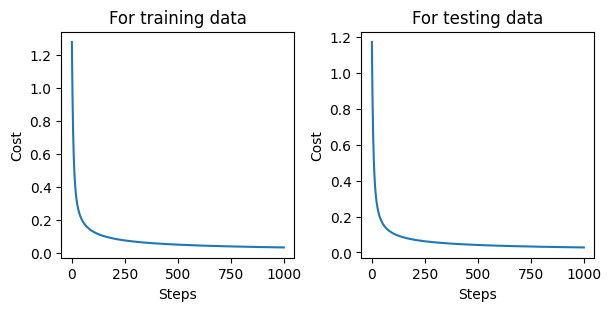


Minimum train cost: 0.032316286116838455
Minimum test cost: 0.02760905772447586
--END OF TRAINING--



In [ ]:
# Training for the class "setosa":
setosa = Flower(0)
setosa.train()

How does the cost of the 4 attribute model compare to the previous one?

---

## Question 6.1
Now train classifiers for the other two classes.[1 mark]

TRAINING FOR CLASS: versicolor


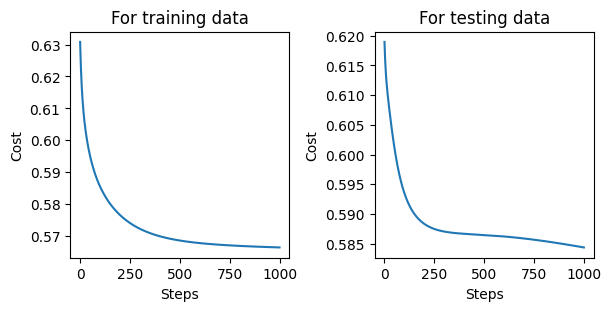


Minimum train cost: 0.5663292407989502
Minimum test cost: 0.584384560585022
--END OF TRAINING--

TRAINING FOR CLASS: virginica


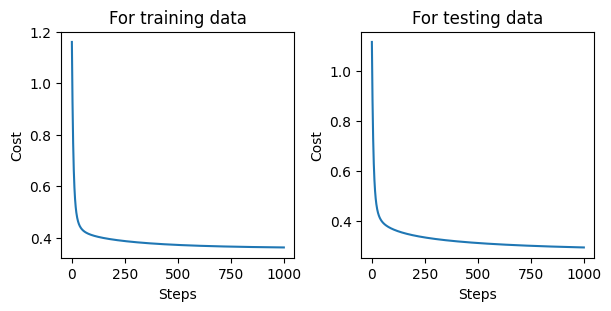


Minimum train cost: 0.3615633547306061
Minimum test cost: 0.29398199915885925
--END OF TRAINING--



In [ ]:
# Defining the classes:
versicolor = Flower(1)
virginica = Flower(2)

# Training for the above classes:
versicolor.train()
virginica.train()

## Question 6.2
<u><font color="maroon">Using the 3 classifiers, predict the classes of the samples in the test set and show the predictions in a table. Do you observe anything interesting? [4 marks] </font></u>

In [ ]:
y = y_test.reshape(-1).numpy()
isSetosa = setosa.model(x_test).detach().reshape(-1).numpy()
isVersicolor = versicolor.model(x_test).detach().reshape(-1).numpy()
isVirginica = virginica.model(x_test).detach().reshape(-1).numpy()
"""
NOTE ON RESHAPING:
`.reshape()` was used to convert the variables from a column vector with multiple
rows of size 1 into a 1-D array (i.e. a row vector). This is done to pass the
data smoothly into the dataframe (where each column needs to be a 1-D array).
"""

# Obtaining data to display:
data = {}
data["class"] = y
data["isSetosa"] = isSetosa
data["isVersicolor"] = isVersicolor
data["isVirginica"] = isVirginica

# Obtaining softmax-based predicted classes:
indexWithMaxProbability = []
for i in range(len(isSetosa)):
  p = [isSetosa[i], isVersicolor[i], isVirginica[i]]
  indexWithMaxProbability.append(p.index(max(p)))

data["indexWithMaxProbability"] = indexWithMaxProbability

# Creating the dataframe:
pd.DataFrame(data=data)

,class,isSetosa,isVersicolor,isVirginica,indexWithMaxProbability
0,1,0.032685,0.755665,0.465549,1
1,0,0.999955,0.168087,0.110785,0
2,2,0.000003,0.836836,0.946450,2
3,1,0.038897,0.591972,0.705988,2
4,1,0.007348,0.763097,0.534726,1
5,0,0.999644,0.300555,0.079738,0
6,1,0.293490,0.539614,0.524675,1
7,2,0.002156,0.346899,0.966958,2
8,1,0.000456,0.909671,0.383106,1
9,1,0.076969,0.730969,0.373267,1


**OBSERVATIONS**:<br> Above, we see that the class with the highest probability based on a binary 1 vs many classification (i.e., for a given class $C$, we reduce the set of possible classes for the data to $C$ or _not_ $C$) generally coincides with the actual (non-binary) class of the data. Here, we have indexed the classes with respect to their integer labels; her we see that the index with the highest probability generally coincides with the actual class label mapped to the data.

<font color="blue">**Ambiguity problem**:

The probability values for certain observations may be such that there is no clear classification for it, i.e. the classification is ambiguous due to the probability values being close to each other. This gives rise to the ambiguity problem, wherein the classification of an observation is ambiguous (even if there may be a discrete class assigned to it based on the probabilities).</font>

**Confident misclassifications**:

We also get some indication that this method of multi-classification may not be the completely reliable, as we see some correct predictions being correct by a small margin (i.e. a small difference in the probabilities for those classes), <font color="blue">indicating ambiguity</font>...

```
18 | 1	0.053554 |	0.671647	 | 0.577937	| 1
```

... or wrong classification by a large margin...

```
15	| 1	0.147984	| 0.340691	| 0.863798	| 2
```

## Question 7
<u><font color="maroon">Calculate the accuracy of the classifier on the test set, by comparing the predicted values against the ground truth. Use a softmax for the classifier outputs. [1 mark] </font></u>

### About softmax & accuracy for multiclass classifier

#### Softmax
Softmax is a mathematical function that converts a vector of numbers into a vector of values between 0 and 1 (which can be interpreted as probabilities in certain contexts), where the value for each number is proportional to the relative scale of that number in the vector. In other words, we obtain the value of each number $x$ as a ratio of $f(x)$ with respect to all the other values of $f$ for each number of the vector; $f$ is chosen based on the following requirements:

- It should be positively valued (so it is easier to map to $[0,1]$)
- $x \propto f(x)$ (i.e. proportionality should be maintained)
- $\frac{x_1}{x_2} \propto \frac{f(x_1)}{f(x_2)}$ (i.e. relative proportionality should be maintained)

The function $f(x)=e^x$ fulfills these conditions. Thus, the softmax function is defined as:

$
\sigma(\vec{z})_i = \frac{e^{z_i}}{\sum_{k=1}^{K} e^{z_k}}
$

**NOTE**: $\sigma(\vec{z})_i$ is the softmax value for the $i$th element of vector $\vec{z}$, and $K$ is the number of elements in $\vec{z}$.
<br><br>
In the case of classification, our vector is $xw^T$ (_we are matching the dimensionalities of our current implementation_), where $x$ is a row vector denoting an observation consisting of the values of $K$ features along with a bias term $1$, and $w$ is the column vector consisting of $K$ weights along with a bias; these weights and the bias are based on some model mapping input vectors $x$ to an output value. If there are a set of classes $y=1,2 ... K$, the softmax function with respect to a certain class $c$ maps each element of $x^Tw$ to the probability of the object (to which the observation $x$ applies) being in the class $c$. The goal of training is to adjust the weights such that this classification becomes accurate. Clearly, this is a binary classification, as it only concerns with membership to a single class; even if $y$ can take many values, softmax only lets us check membership for one class at a time. Thus, the softmax value of an object to which a certain observation $x$ refers, with a certain class $c$ to which this object may or may not belong, is given by:

$
P(y=c|x,W)=\frac{e^{xw_c^T}}{\sum_{k=1}^{K} e^{xw_k^T}}
$

**NOTE**: $w_k$ is vector of weights belonging to the classifier model for class $k$, and $K$ is the total number of classes. $W$ is the matrix where each row vector is the vector of weights for the a different class' classifier model (altogether covering all classes).

**SIDE NOTE**: _The softmax function reduces to the sigmoid function (used in logistic regression) when_ $K=2$.

> REFERENCES:
>
> - https://machinelearningmastery.com/softmax-activation-function-with-python/
> - https://www.turing.com/kb/softmax-multiclass-neural-networks

---

#### Accuracy function
Let $M$ be the total number of observations (involving $N$ features), let $K$ be the total number of classes we are considering, and let $y$ be a variable to denote the class (it can take one of $K$ values). Hence, we define the following matrices:

- $X_{M \times N}$: Each row vector is a single observation
- $Y_{M \times K}$ Each row vector $v_i$ is the vector of indicators equalling either $0$ or $1$ for the corresponding observation;
  - $0 \implies$ "not in class $v_i$"
  - $1 \implies$ "is in class $v_i$"
  - Hence, if $y=j$ for observation $i$, $Y_{ij}=1$, else $0$
- $W_{K \times N}$ is the matrix where each row vector is the vector of weights for the corresponding class' classifier model

In the one vs. many multiclass classifier, we performed a simple binary classification for each class, obtaining the weights above and thus obtaining the probability of belonging to each class (given by the softmax function). We shall use this to obtain the accuracy. Initialising $a=0$, for each observation $i$, do the following...

- Get the index $j \in {1, 2 ... K}$ for which he softmax value is maximum; $j$ is thus the prediction
- Only if $Y_{ij}=1$, increment $a$ by $1$

After finishing the above process, divide $a$ by the total number of observations, which equals the total number of predictions. This is the accuracy. In general:

$Accuracy=\frac{nCorrectObservations}{nTotalObservations}$

Implementing the above accuracy function...

In [ ]:
classList = (setosa, versicolor, virginica) # Global variable

# Helper function to get the softmax value for a given observation & class:
def softmax(x, classIndex, classList=classList):
  """
  We expect x to be a row of predictor variable values (with bias term).
  classIndex indicates which class to calculate softmax for.
  classList is the whole list of possible classes.
  """
  V = []
  for C in classList:
    w = C.model.state_dict()['0.weight'] # Obtains the weights of the model
    V.append(torch.exp(x @ torch.transpose(w, 0, -1)))
  return V[classIndex]/sum(V)

#================================================

# The main accuracy function:
def get_accuracy(x, y, K=3):
  a = 0
  for i in range(x.shape[0]):
    pMax, jMax = 0, 0
    for j in range(K):
      p_ij = softmax(x[i], j)
      if p_ij > pMax: pMax, jMax = p_ij, j
    if y[i, jMax] == 1: a += 1
  return a/y.shape[0]

In [ ]:
# Testing the softmax function:
tr = softmax(x_train[0], 0), softmax(x_train[0], 1), softmax(x_train[0], 2)
te = softmax(x_test[0], 0), softmax(x_test[0], 1), softmax(x_test[0], 2)
print(f"VALUES={tr}\nSUM={sum(tr)}")
print(f"\nVALUES={te}\nSUM={sum(te)}")

VALUES=(tensor([1.0000]), tensor([2.3328e-06]), tensor([9.5442e-07]))
SUM=tensor([1.0000])

VALUES=(tensor([0.0085]), tensor([0.7736]), tensor([0.2179]))
SUM=tensor([1.])


In [ ]:
# Getting the training & testing accuracy:
print(f"""ACCURACY
Training accuracy: {get_accuracy(x_train, y_train_oneHot):.3f},
Testing accuracy: {get_accuracy(x_test, y_test_oneHot):.3f}""")

ACCURACY
Training accuracy: 0.842,
Testing accuracy: 0.900


# 3. The XOR problem


## Question 8
<u><font color="maroon">Looking at the datapoints below, can we draw a decision boundary using Logistic Regression? Why? What are the specific issues of logistic regression with regards to XOR? [2 marks] </font></u>

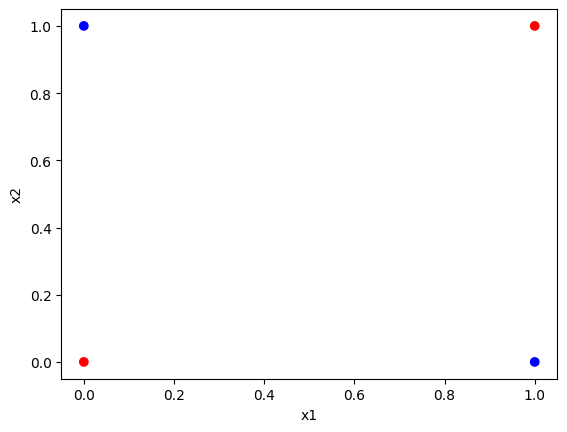

In [ ]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

**OBSERVATION**:<br>The data above is not linearly separable, i.e. there is no straight line that can suitably divide the points above with respect to their classes. Logistic regression is a linear classifier, which means it partitions the data into one of two classes by checking on which side of a single threshold value the linear combination of inputs and weights lie. Thus, logistic regression by itself is ill-equiped to deal with non-linear class boundaries such as in XOR.